In [22]:
import os
from scipy.optimize import least_squares

In [2]:
os.chdir('/Users/niudu/Google Drive/LHCX_DB/Results/2017_01_18-11_08_16')

In [4]:
import pickle

In [6]:
pickle_file = open('inquery_results.pkl','rb')
with pickle_file:
    results = pickle.load(pickle_file)

In [14]:
import pandas as pd
import matplotlib.pyplot as plt 
%matplotlib inline

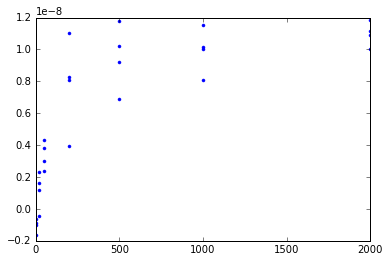

In [16]:
plt.plot(results.Light_level,results.Oxygen_evolution,'.')

In [18]:
import seaborn as sns
results.head()

Light_level  Oxygen_evolution  Oxygen_respiration  \
103116_LHCX_WT_0Hr_R1 0          0.0     -6.442513e-10        6.442513e-10   
                      1         20.0      1.157534e-09        4.214432e-10   
                      2         50.0      3.790291e-09        1.054282e-09   
                      3        200.0      8.265140e-09        8.156848e-10   
                      4        500.0      1.024876e-08        1.120293e-09   

                         Oxygen_evolution_gross  \
103116_LHCX_WT_0Hr_R1 0            0.000000e+00   
                      1            1.578977e-09   
                      2            4.844572e-09   
                      3            9.080825e-09   
                      4            1.136905e-08   

                         Respiration_to_Photosynthesis  Carbon_respiration  \
103116_LHCX_WT_0Hr_R1 0                            NaN        1.643707e-09   
                      1                       0.266909        8.497027e-10   
                      2                       0.217621        4.467012e-10   
                      3                       0.089825        4.800351e-10   
                      4                       0.098539        1.180477e-09   

                         Carbon_uptake  Carbon_uptake_net  \
103116_LHCX_WT_0Hr_R1 0   0.000000e+00      -1.643707e-09   
                      1   1.271196e-10      -7.225831e-10   
                      2   1.588324e-09       1.141622e-09   
                      3   5.066536e-09       4.586501e-09   
                      4   5.705668e-09       4.525191e-09   

                         C_Respiration_to_Photosynthesis  
103116_LHCX_WT_0Hr_R1 0                              NaN  
                      1                         6.684276  
                      2                         0.281241  
                      3                         0.094746  
                      4                         0.206895

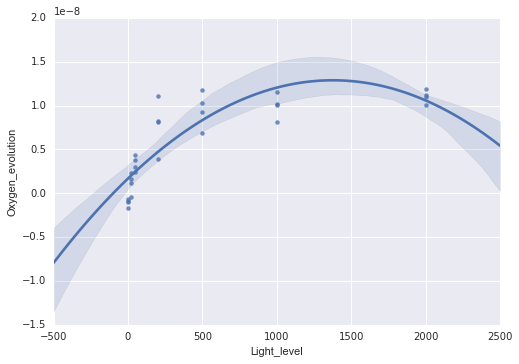

In [20]:
sns.regplot(x=results["Light_level"], y=results["Oxygen_evolution"])

In [21]:
def Platt(coef,E,P):

    return coef[0]*(1-np.exp(-(coef[1]*E)/coef[0])) - P # *np.exp((-1*coef[2]*E)/coef[0]) - P

def PvE_func(Light_level,P_data_ori):
    # E_prim and E_prim_culture refers to the E' of the sample in pH-MIMS system and culture. The values are not used in this function
    # Here they are simply transfferred to the data framework that will be referened in other functions
    try:
        scale_up = 10**int(-np.log10(np.median(P_data_ori)/100))
    except ValueError:
        scale_up = 10**10

    # Check if the first data point is negative
    offset = 0
    if min(P_data_ori)<0:
        offset = -1*min(P_data_ori)*scale_up
        P_data = P_data_ori*scale_up + offset
    else: P_data = P_data_ori*scale_up
    G_alpha = stats.linregress(Light_level[0:4],P_data[0:4]).slope
    G_alpha = 10**(-10) if (G_alpha < 0.0) else G_alpha
    # G_beta = 0
    G_Ps = max(P_data)
    # The non-linear regression funciton in scipy does not work well on extremely small numbers, therefore must be scaled up
    # Scale = -round(np.log10(G_alpha))
    
    coef_0 = np.array([G_Ps,G_alpha], dtype=float)
    
    # Start non-linear fitting
    res_lsq = least_squares(Platt, coef_0, loss='soft_l1',  args=(Light_level, P_data)) 
    coef = res_lsq.x/scale_up
    #Scale back

    # The calculation of P shall be done outside this function
    # E0 = pd.DataFrame(list(np.arange(0,max(Light_level)*1.01,max(Light_level)/100)))  
    # Prod = Platt(coef[0:2],E0,offset/scale_up)
    Ek = coef[0]/coef[1]
   
    # Pm = coef[0]*(coef[1]/(coef[1]+coef[2]))*((coef[2]/(coef[1]+coef[2]))**(coef[2]/coef[1]))
    
    return list(coef)+[Ek]+[offset/scale_up]